# Project Second Edition
    by Xiao Li, Dec. 16th 2018
## I made several changes in this version:
1. Delete some unwanted features and rerun the model.
2. Make a table for mutual information and feature importance of desicion tree and coefficients in svm in descending order(I didn't do histogram since there's too many features, a single histogram may be messy) and train models after feature reduction by mutual information and do parameter tuning on the new models.
3. Make a Random Forest Classifier.
4. Use Grid Search to find the best model for predicting attrition.
4. Make cumulative gain curve.
5. Try to come up with a solution to reduce attrition rate(draft).

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import is_string_dtype
from sklearn import preprocessing

In [180]:
# Read data
datadir = os.getcwd()
data = pd.read_csv(datadir + '/' + 'WA_Fn-UseC_-HR-Employee-Attrition.csv')
# Do some cleaning
# Firstly, make the attrition column numeric, so that 1 for 'yes' and 0 for 'no'
data_clean = data.copy()
Attrition_result = np.array((data_clean['Attrition'] == 'Yes').astype(int))
data_clean = data_clean.drop(['Attrition'], axis = 1)
# Now we check if we have any null value in our dataset
if data_clean.isnull().any().any():
    print('No!!!!!!!!!!')
# Gladly, we don't have any null value, so now let's do something about categorical variable
# Remove variables that is the same all the time and not meaningful variables
data_clean = data_clean.drop(['Over18', 'StandardHours', 'EmployeeCount', 'EmployeeNumber'], axis = 1)
# For each categorical variables in the dataset, try to assign an unique indicator variable 
#      for each different category
col_name_dict = {}
for col in data_clean.columns:
    if is_string_dtype(data_clean[col]):
        name_set = set(data_clean[col])
        col_name_dict[col] = name_set
        for name in name_set:
            data_clean[' '.join([col, name, 'indicator'])] = (data_clean[col] == name).astype(int)
        data_clean = data_clean.drop(col, axis = 1)
# Now do some preprocessing so that all the features in our dataset have mean 0 and std 1 for
#      future convenience
scale = preprocessing.StandardScaler()
scale.fit(data_clean)
data_clean = pd.DataFrame(scale.transform(data_clean), columns = data_clean.columns)
data_clean['Attrition'] = Attrition_result

In [168]:
# So our dataset will look like this
data_clean.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole Manager indicator,JobRole Human Resources indicator,JobRole Healthcare Representative indicator,JobRole Research Director indicator,MaritalStatus Single indicator,MaritalStatus Married indicator,MaritalStatus Divorced indicator,OverTime No indicator,OverTime Yes indicator,Attrition
0,0.446350,0.742527,-1.010909,-0.891688,-0.660531,1.383138,0.379672,-0.057788,1.153254,-0.108350,...,-0.273059,-0.191498,-0.312785,-0.239904,1.458650,-0.918921,-0.534873,-1.591746,1.591746,1
1,1.322365,-1.297775,-0.147150,-1.868426,0.254625,-0.240677,-1.026167,-0.057788,-0.660853,-0.291719,...,-0.273059,-0.191498,-0.312785,-0.239904,-0.685565,1.088232,-0.534873,0.628241,-0.628241,0
2,0.008343,1.414363,-0.887515,-0.891688,1.169781,1.284725,-1.026167,-0.961486,0.246200,-0.937654,...,-0.273059,-0.191498,-0.312785,-0.239904,1.458650,-0.918921,-0.534873,-1.591746,1.591746,1
3,-0.429664,1.461466,-0.764121,1.061787,1.169781,-0.486709,0.379672,-0.961486,0.246200,-0.763634,...,-0.273059,-0.191498,-0.312785,-0.239904,-0.685565,1.088232,-0.534873,-1.591746,1.591746,0
4,-1.086676,-0.524295,-0.887515,-1.868426,-1.575686,-1.274014,0.379672,-0.961486,-0.660853,-0.644858,...,-0.273059,-0.191498,-0.312785,-0.239904,-0.685565,1.088232,-0.534873,0.628241,-0.628241,0


In [89]:
# Now build some baseline model for predicting attrition
# Since this is just a baseline model, split data into 80%, 20% so that the first part would be
#      used for training and the later part would be used for testing
train_index = []
test_index = []
length = len(data_clean['Attrition'])
for i in range(0, length):
    train_index.append(i) if np.random.rand() <= 0.8 else test_index.append(i)
data_train = data_clean.iloc[train_index, :]
data_test = data_clean.iloc[test_index, :]

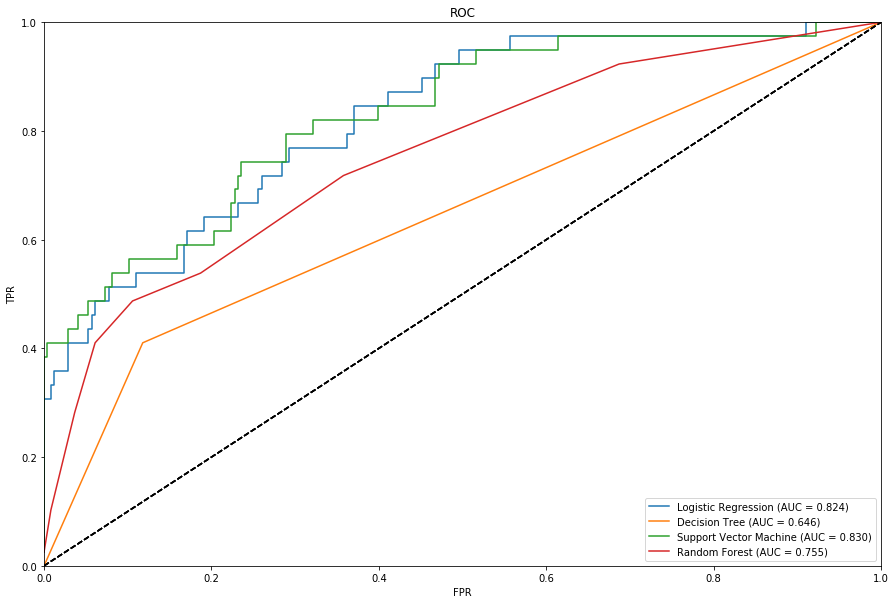

In [273]:
# I want to try logistic regression, decision tree, support vector machine
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

# Build models and predict
# Logistic regression
lg = linear_model.LogisticRegression(C = 1e30)
lg.fit(data_train.drop(['Attrition'], axis = 1), data_train['Attrition'])
result_lg = lg.predict_proba(data_test.drop(['Attrition'], axis = 1))[:, 1]
# Decision Tree
DT = DecisionTreeClassifier()
DT.fit(data_train.drop(['Attrition'], axis = 1), data_train['Attrition'])
result_DT = DT.predict_proba(data_test.drop(['Attrition'], axis = 1))[:, 1]
# Support vector machine
our_svm = svm.SVC(kernel = 'linear', probability = True)
our_svm.fit(data_train.drop(['Attrition'], axis = 1), data_train['Attrition'])
result_svm = our_svm.predict_proba(data_test.drop(['Attrition'], axis = 1))[:, 1]
# Random Forest
rf = RandomForestClassifier()
rf.fit(data_train.drop(['Attrition'], axis = 1), data_train['Attrition'])
result_rf = rf.predict_proba(data_test.drop(['Attrition'], axis = 1))[:, 1]

def plotROC(preds, truth, name):
    fpr, tpr, thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)
    # chooses a random color for plotting
    #c = (np.random.rand(), np.random.rand(), np.random.rand())
    #create the plot
    plt.plot(fpr, tpr, label = name + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

# Plot ROC for logistic regression
fig = plt.figure(figsize = (15, 10))
plotROC(result_lg, data_test['Attrition'], 'Logistic Regression')
plotROC(result_DT, data_test['Attrition'], 'Decision Tree')
plotROC(result_svm, data_test['Attrition'], 'Support Vector Machine')
plotROC(result_rf, data_test['Attrition'], 'Random Forest')
plt.show()

So here is our baseline model, it looks like logistic regression and support vector machine did pretty similar job while decition tree is doing badly, this may be the result that I chose the wrong paramter, which we'll try to fix it later.<br>
Ok so for next step, try to find the best parameter and also make some plot for the relationships between features.<br>
I'll start with finding best parameter.

In [91]:
# Since we have limited amount of samples, we better use cross validation to find the best parameter
from sklearn.model_selection import KFold
def find_best_parameter(k, cs, lgc, min_split_values, min_leaf_values):
    # Note that 'k' is for deciding how many folders do we want to use, 'cs' is a list for
    #      parameters for support vector machine we want to try, 'lgc' is a list for parameters
    #      of logistic regression and the last two are both for decision tree
    # Create a KFold using parameter k and create an empty dictionary
    KF = KFold(n_splits = k)
    aucs_dt = {}
    aucs_svm = {}
    aucs_lg = {}
    # Dividing dataset by folds
    for train_ind, test_ind in KF.split(data_train):
        cv_train = data_train.iloc[train_ind]
        cv_validate = data_train.iloc[test_ind]
        # Find best parameter for Decision Tree
        # Calculate roc_auc_score for different parameters and store them in the dictionary
        count = len(min_split_values)
        for i in range(0, count):
            for j in range(0, count):
            # Construct a decision tree for each set of values
                dt = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = min_split_values[i],
                                   min_samples_leaf = min_leaf_values[j])
                dt.fit(cv_train.drop('Attrition', 1), cv_train['Attrition'])
                Attrition_DT = dt.predict_proba(cv_validate.drop(['Attrition'], axis = 1))[:, 1]
                aucdt = roc_auc_score(cv_validate['Attrition'], Attrition_DT)
                key = (' ').join([str(min_split_values[i]), str(min_leaf_values[j])])
                # Put on some tracker
                print(key)
                if key in aucs_dt:
                    aucs_dt[key].append(aucdt)
                else:
                    aucs_dt[key] = [aucdt]
        # Find best parameter for support vector machine
        for c in cs:
            new_svm = svm.SVC(C = c, kernel = "linear", gamma = 'auto')
            new_svm.fit(cv_train.drop(['Attrition'], axis = 1), cv_train['Attrition'])
            aucsvm = roc_auc_score(cv_validate['Attrition'], 
                                    new_svm.decision_function(cv_validate.drop(['Attrition'], axis = 1)))
            print(c)
            if c in aucs_svm:
                aucs_svm[c].append(aucsvm)
            else:
                aucs_svm[c] = [aucsvm]
        # Find best parameter for logistic regression
        for c in lgc:
            new_lg = linear_model.LogisticRegression(C = c)
            new_lg.fit(cv_train.drop(['Attrition'], axis = 1), cv_train['Attrition'])
            print(c)
            auclg = roc_auc_score(cv_validate['Attrition'], 
                                    new_lg.predict_proba(cv_validate.drop(['Attrition'], axis = 1))[:, 1])
            if c in aucs_lg:
                aucs_lg[c].append(auclg)
            else:
                aucs_lg[c] = [auclg]
    return [aucs_dt, aucs_svm, aucs_lg]

In [ ]:
# Find them!
min_samples_split_values = []
min_samples_leaf_values = []
for i in range(1, 31):
    min_samples_split_values.append(10 * i)
    min_samples_leaf_values.append(2 * i)
cs = [10 ** i for i in range(-7, 3)]
lgc = [10 ** i for i in range(0, 30)]
aucs = find_best_parameter(5, cs, lgc, min_samples_split_values, min_samples_leaf_values)

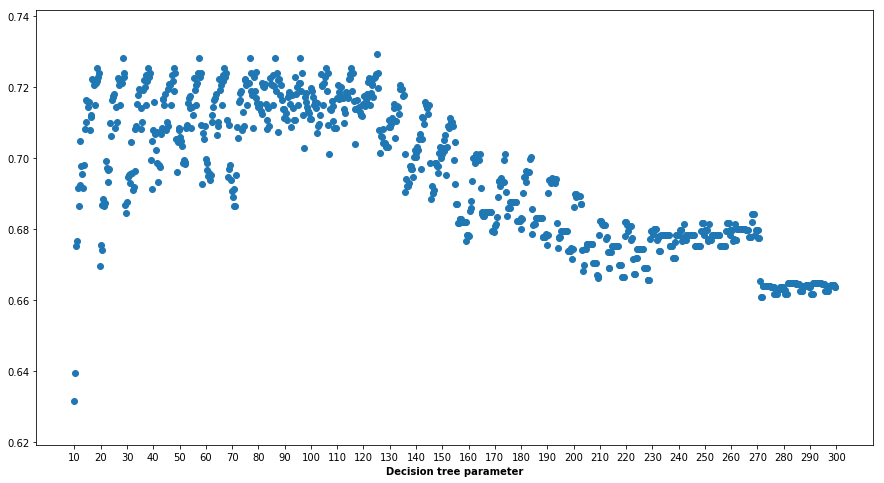

In [93]:
dt_pa = aucs[0]
svm_pa = aucs[1]
lg_pa = aucs[2]
dt_parameter = [np.mean(dt_pa[key]) for key in dt_pa]
svm_parameter = [np.mean(svm_pa[key]) for key in svm_pa]
lg_parameter = [np.mean(lg_pa[key]) for key in lg_pa]
# Now make some plot
# Firstly, plot for results in decision tree and paramter
fig, ax = plt.subplots(figsize = (15,8))
dt_p = ax.scatter(range(0, len(dt_parameter)), dt_parameter)
plt.xlabel('Decision tree parameter', fontweight='bold')
ax.set_xticks(np.linspace(0, len(dt_parameter), 30))
ax.set_xticklabels(min_samples_split_values)
plt.show()

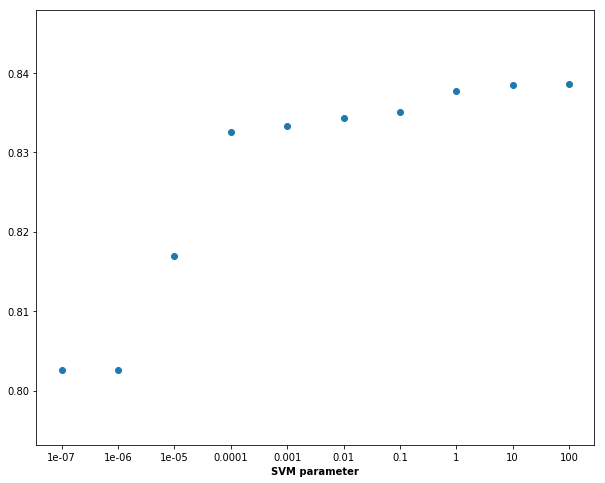

In [94]:
# Secondly, plot for results in svm and paramter
fig, ax = plt.subplots(figsize = (10,8))
svm_p = ax.scatter(np.linspace(cs[0], cs[-1], 10), svm_parameter)
plt.xlabel('SVM parameter', fontweight='bold')
ax.set_xticks(np.linspace(cs[0], cs[-1], 10))
ax.set_xticklabels(cs)
plt.show()

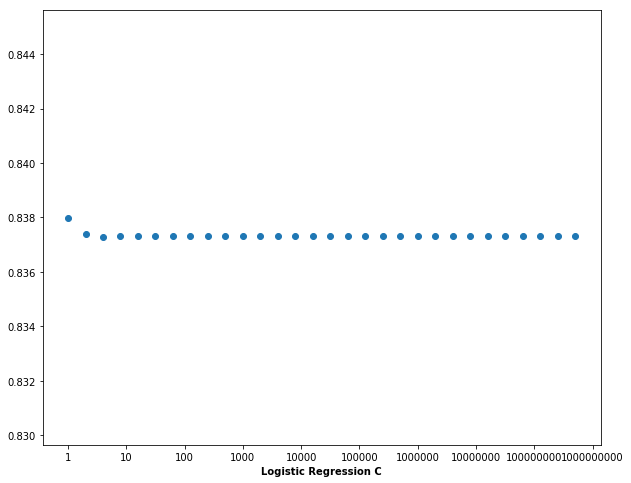

In [95]:
# Thirdly, plot for results in logistic regression and paramter
fig, ax = plt.subplots(figsize = (10,8))
lg_p = ax.scatter(range(0, len(lg_parameter)), lg_parameter)
ax.set_xticks(np.linspace(0, len(lg_parameter), 10))
ax.set_xticklabels(lgc)
plt.xlabel('Logistic Regression C', fontweight = 'bold')
plt.show()

In [96]:
# Find the best parameter
bestkey_dt = list(dt_pa.keys())[np.argmax(dt_parameter)]
bestkey_dt

'120 56'

In [97]:
# Best parameter for svm
bestkey_svm = list(svm_pa.keys())[np.argmax(svm_parameter)]
bestkey_svm

100

In [275]:
# Do a parameter tuning for Random Forest
from sklearn.model_selection import GridSearchCV

# Create a parameter grid to sample from during fitting
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', "log2", None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ['gini', 'entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               "criterion": criterion}

In [276]:
# Use the random grid to search for best hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 10, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(data_train.drop("Attrition", 1), data_train['Attrition'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=80, criterion=entropy, bootstrap=False 
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=80, criterion=entropy, bootstrap=False 
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=80, criterion=entropy, bootstrap=False 
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True, total=   0.5s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True, tota

[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=80, criterion=gini, bootstrap=False, total=   1.0s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.7s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt', 'log2', None], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [277]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': False}

In [278]:
# Train a model with these parameters
rf_1 = rf_random.best_estimator_
rf_1.fit(data_train.drop("Attrition", 1), data_train['Attrition'])
rf_1_pred = rf_1.predict_proba(data_test.drop("Attrition", 1))
# Get AUC
roc_auc_score(data_test["Attrition"], rf_1_pred[:,1])

0.7897644361058995

In [ ]:
# Create the parameter grid based on the results of random search 
search_grid = {
    'bootstrap': [False],
    'max_depth': [30, 40, 50, 60],
    'max_features': ['auto', None],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 400, 600, 800],
    'criterion': ['gini', 'entropy']
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = search_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(data_train.drop('Attrition', 1), data_train['Attrition'])

print(grid_search.best_params_)

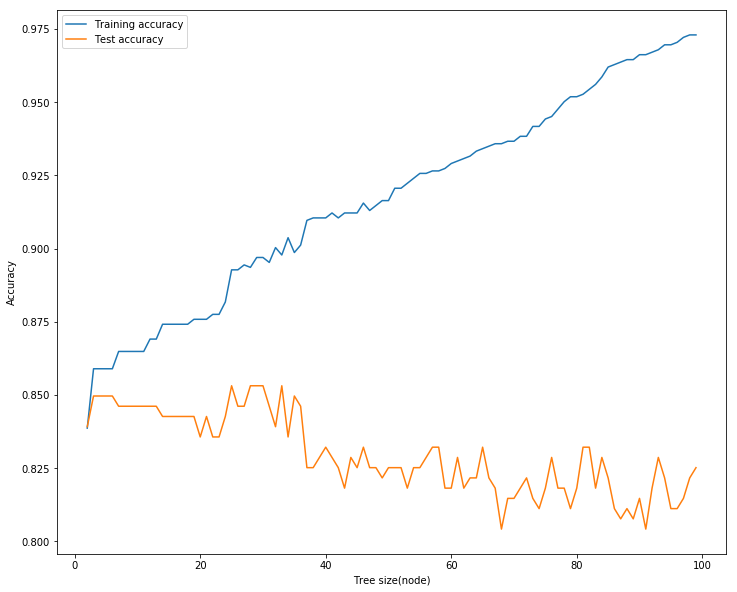

In [12]:
# Here I provide a plot for relationship between tree nodes in decision tree and the accuracy
# We could do the same for svm and logistic regression as well, but since I'm lazy, I'll only do decision tree...
from sklearn.metrics import accuracy_score
acc_train = []
acc_test = []
for i in range(2, 100):
    dt_plot = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = i)
    dt_plot.fit(data_train.drop(['Attrition'], axis = 1), data_train['Attrition'])
    acc_train.append(accuracy_score(data_train['Attrition'], 
                                    dt_plot.predict(data_train.drop(['Attrition'], axis = 1))))
    acc_test.append(accuracy_score(data_test['Attrition'], 
                                    dt_plot.predict(data_test.drop(['Attrition'], axis = 1))))
x_axis = np.array(range(2, 100))
fig_dt = plt.figure(figsize = (12,10))
plt.plot(x_axis, acc_train, label = 'Training accuracy')
plt.plot(x_axis, acc_test, label = 'Test accuracy')
plt.xlabel("Tree size(node)")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

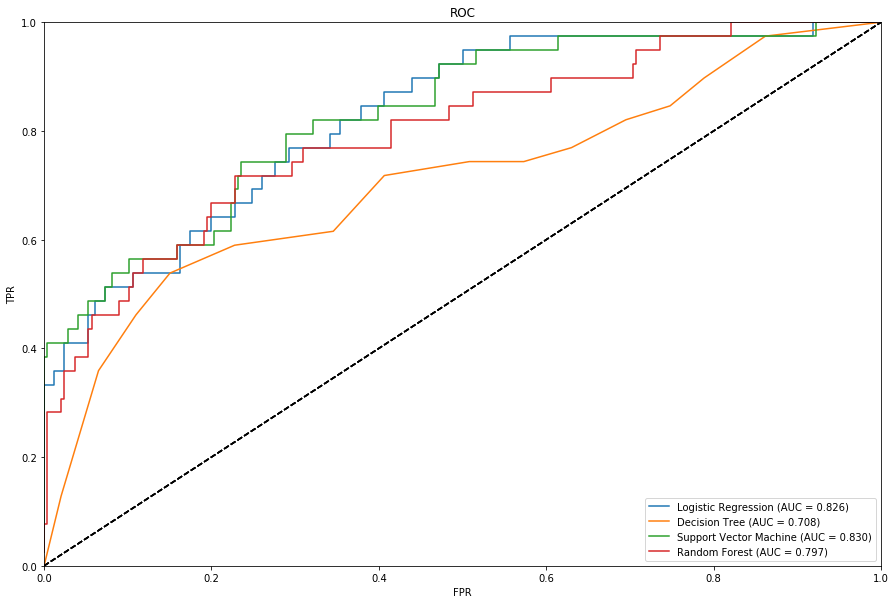

In [285]:
# Create ROC curve and get result again use the good parameters
# Logistic regression
good_lg = linear_model.LogisticRegression()
good_lg.fit(data_train.drop(['Attrition'], axis = 1), data_train['Attrition'])
Result_lg = good_lg.predict_proba(data_test.drop(['Attrition'], axis = 1))[:, 1]
# Decision Tree
good_DT = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 120, min_samples_leaf = 56)
good_DT.fit(data_train.drop(['Attrition'], axis = 1), data_train['Attrition'])
Result_DT = good_DT.predict_proba(data_test.drop(['Attrition'], axis = 1))[:, 1]
# Support vector machine
good_svm = svm.SVC(kernel = 'linear', C = 1, probability = True)
good_svm.fit(data_train.drop(['Attrition'], axis = 1), data_train['Attrition'])
Result_svm = good_svm.predict_proba(data_test.drop(['Attrition'], axis = 1))[:, 1]
# Random Forest
good_rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 200, 
                                 min_samples_split = 8, min_samples_leaf = 1, max_depth = 30)
good_rf.fit(data_train.drop(['Attrition'], axis = 1), data_train['Attrition'])
Result_rf = good_rf.predict_proba(data_test.drop(['Attrition'], axis = 1))[:, 1]
# plot
fig = plt.figure(figsize = (15, 10))
plotROC(Result_lg, data_test['Attrition'], 'Logistic Regression')
plotROC(Result_DT, data_test['Attrition'], 'Decision Tree')
plotROC(Result_svm, data_test['Attrition'], 'Support Vector Machine')
plotROC(Result_rf, data_test['Attrition'], 'Random Forest')
plt.show()

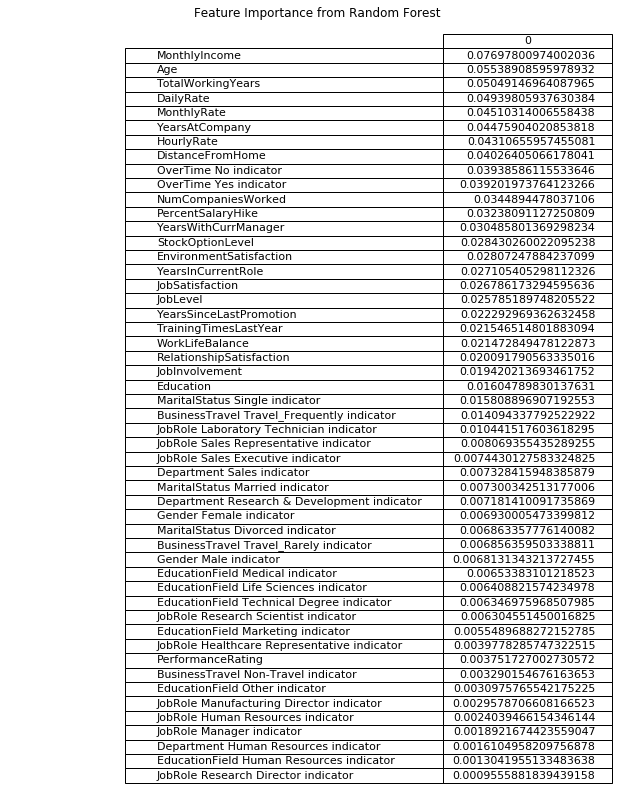

In [289]:
from pandas.plotting import table
col_list = list(data_clean.columns)
col_list.remove('Attrition')
FI_dict = dict(zip(col_list, list(good_rf.feature_importances_)))
FI_df = pd.DataFrame.from_dict(FI_dict, orient = 'index').sort_values(by = 0, ascending = False)

fig, ax = plt.subplots(figsize=(11, 10)) # set size frame 
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, FI_df, loc='upper right', colWidths=[0.23]*len(FI_df.columns))
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(11) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) # change size table
plt.title('Feature Importance from Random Forest')
#plt.savefig('table.png', transparent=True)
plt.show()

In [69]:
# Find mutual information between features and target variables(this gives us hint about which features
#     predict the target variable well)
from sklearn.feature_selection import mutual_info_classif as mic
mi_list = mic(data_clean.drop('Attrition', axis = 1).values, data_clean['Attrition'].values)
mi_dict = dict(zip(col_list, list(mi_list)))
mi_dict

{'Age': 0.033052820732690114,
 'DailyRate': 0.0,
 'DistanceFromHome': 0.0,
 'Education': 0.0,
 'EnvironmentSatisfaction': 0.00043677174084821857,
 'HourlyRate': 0.0,
 'JobInvolvement': 0.0,
 'JobLevel': 0.045058039119793,
 'JobSatisfaction': 0.019168485084734677,
 'MonthlyIncome': 0.033729928271344134,
 'MonthlyRate': 0.002117200777766781,
 'NumCompaniesWorked': 0.0,
 'PercentSalaryHike': 0.0,
 'PerformanceRating': 0.0018130364728639048,
 'RelationshipSatisfaction': 0.0,
 'StockOptionLevel': 0.017973703576334765,
 'TotalWorkingYears': 0.02132804175829972,
 'TrainingTimesLastYear': 0.010447963224052392,
 'WorkLifeBalance': 0.007852873777189906,
 'YearsAtCompany': 0.0019880646642953526,
 'YearsInCurrentRole': 0.024145828896673383,
 'YearsSinceLastPromotion': 0.0015026050276760738,
 'YearsWithCurrManager': 0.0048807147142342355,
 'BusinessTravel Travel_Rarely indicator': 0.009949488392666073,
 'BusinessTravel Travel_Frequently indicator': 0.0048122104750485395,
 'BusinessTravel Non-Travel

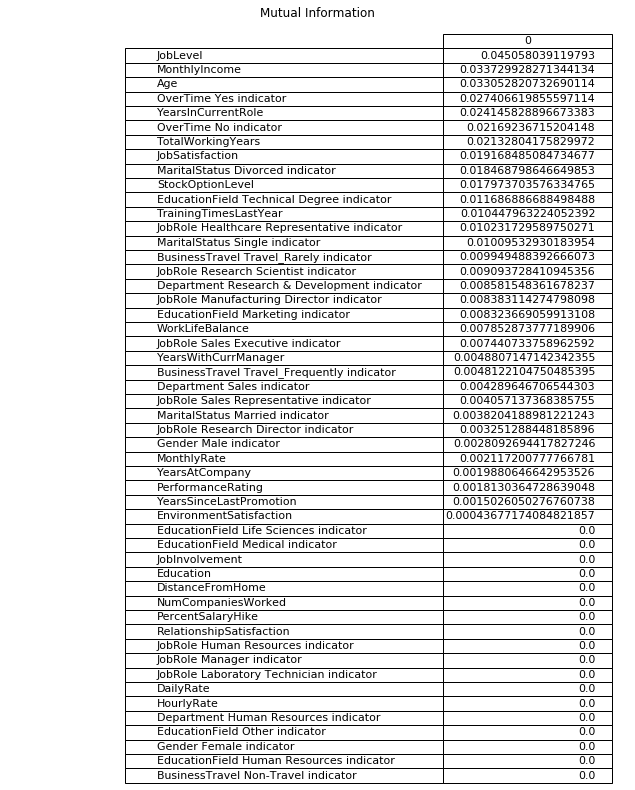

In [70]:
mi_df = pd.DataFrame.from_dict(mi_dict, orient = 'index').sort_values(by = 0, ascending = False)

fig, ax = plt.subplots(figsize=(11, 10)) # set size frame 
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, mi_df, loc='upper right', colWidths=[0.23]*len(mi_df.columns))
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(11) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) # change size table
plt.title('Mutual Information')
#plt.savefig('table.png', transparent=True)
plt.show()

In [73]:
# Since we have too much features and relatively less instances, we could remove some features and check result
# We cut features with mi less than 005
mi_to_rm = set(data_clean.columns) - set(mi_df.iloc[:21].index) - set(['Attrition'])
data_mi = data_clean.drop(mi_to_rm, axis = 1)

In [99]:
# Split data into training and test
mi_train = data_mi.iloc[train_index, :]
mi_test = data_mi.iloc[test_index, :]

In [100]:
# Run a parameter tuning
# Do a grid search for decision tree using mutual information
from sklearn.model_selection import GridSearchCV
min_samples_split = []
min_samples_leaf = []
for i in range(1, 11):
    min_samples_split.append(20 * i)
    min_samples_leaf.append(5 * i)
gs_dt_mi = DecisionTreeClassifier()
param_dist = {'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_dt_mi = GridSearchCV(gs_dt_mi, cv = 3,
                     param_grid=param_dist,
                     n_jobs = 3)

cv_dt_mi.fit(mi_train.drop(['Attrition'], axis = 1), mi_train['Attrition'])

print('Best Parameters using grid search: \n',
      cv_dt_mi.best_params_)

Best Parameters using grid search: 
 {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 35, 'min_samples_split': 80}


In [101]:
# Do grid search on Logistic Regression MI
gs_lg = linear_model.LogisticRegression()
param_dist = {'fit_intercept': [True, False],
              'C': [10 ** i for i in range(9)],
              'class_weight': ['balanced', None],
              'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

cv_lg = GridSearchCV(gs_lg, cv = 3,
                     param_grid=param_dist,
                     n_jobs = 3)

cv_lg.fit(mi_train.drop(['Attrition'], axis = 1), mi_train['Attrition'])

print('Best Parameters using grid search: \n',
      cv_lg.best_params_)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best Parameters using grid search: 
 {'C': 1, 'class_weight': None, 'fit_intercept': True, 'solver': 'liblinear'}


In [102]:
# Do grid search on svm MI
gs_svm = svm.SVC(probability = True)
param_dist = {'C': [10 ** i for i in range(-5, 5)]}

cv_svm = GridSearchCV(gs_svm, cv = 3,
                     param_grid=param_dist,
                     n_jobs = 3)

cv_svm.fit(mi_train.drop(['Attrition'], axis = 1), mi_train['Attrition'])

print('Best Parameters using grid search: \n',
      cv_svm.best_params_)

Best Parameters using grid search: 
 {'C': 1}


In [279]:
# Do a grid search on random forest, first random search
# Use the random grid to search for best hyperparameters
mirf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 10, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

# Fit the random search model
mirf_random.fit(mi_train.drop("Attrition", 1), mi_train['Attrition'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=80, criterion=entropy, bootstrap=False 
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=80, criterion=entropy, bootstrap=False 
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=80, criterion=entropy, bootstrap=False 
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True, total=   0.4s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True, tota

[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=80, criterion=gini, bootstrap=False, total=   1.7s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.9s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt', 'log2', None], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [280]:
# Train a model with these parameters
rf_1 = rf_random.best_estimator_
rf_1.fit(mi_train.drop("Attrition", 1), mi_train['Attrition'])
rf_1_pred = rf_1.predict_proba(mi_test.drop("Attrition", 1))
# Get AUC
roc_auc_score(mi_test["Attrition"], rf_1_pred[:,1])

0.7781947050239733

In [291]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': False}

In [292]:
# Create the parameter grid based on the results of random search 
search_grid = {
    'bootstrap': [False],
    'max_depth': [30, 40, 50, 60],
    'max_features': ['auto', None],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 400, 600, 800],
    'criterion': ['entropy']
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = search_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(mi_train.drop('Attrition', 1), mi_train['Attrition'])

print(grid_search.best_params_)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=100 
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=100 
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=100 
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estim

[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   2.5s
[C

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.4s


[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   2.5s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=400, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=400, total=   1.2s
[C

[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=800, total=   3.5s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   1.4s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=Fa

[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=800, total=   2.8s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=600 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=800, total=   2.6s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=800, total=   2.6s
[C

[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=800, total=   2.5s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   59.5s


[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=800, total=   2.6s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.3s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.4s
[CV

[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=200, total=   1.3s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=200, total=   1.3s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=200, total=   1.4s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=400, total=   2.6s
[CV] boot

[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   6.4s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=200, total=   1.7s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   6.7s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=600 
[CV]  bootstrap=F

[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=8, n_estimators=800, total=   5.0s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   1.4s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=8, n_estimators=800, total=   5.5s
[CV]

[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.4s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.4s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=800, total=   5.3s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.6s
[CV] boo

[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.3s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=800, total=   4.5s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=F

[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=800, total=   5.0s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=800, total=   4.5s
[CV]

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.4min


[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] boot

[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   2.9s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=F

[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=600, total=   2.1s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.3s
[CV

[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=600, total=   1.8s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=600, total=   1.8s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] b

[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=600, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=600, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=F

[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=600, total=   1.9s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=600, total=   1.9s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=600, total=   1.8s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bo

[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=400, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=600, total=   1.9s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=600, total=   1.8s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=600, total=   1.9s
[C

[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   2.6s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   3.7s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   3.5s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=F

[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=8, n_estimators=400, total=   2.4s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=8, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=8, n_estimators=400, total=   2.5s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=8, n_estimators=600, total=   3.6s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=8, n_estimators=600, total=   3.4s
[CV] boot

[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=400, total=   2.3s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=400, total=   2.6s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=400, total=   2.6s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=600, total=   3.9s
[C

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.7min


[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=600, total=   3.8s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=600, total=   4.1s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] 

[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=600, total=   3.5s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=600, total=   3.3s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=600, total=   3.6s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.6s
[CV]

[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   4.4s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   3.4s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   3.7s
[CV] bootstrap=False, criterion=entropy, max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=F

[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=400, total=   3.0s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=600, total=   3.5s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=600, total=   3.0s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=600, total=   2.9s
[CV] boot

[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=400, total=   1.4s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=400, total=   1.4s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=600, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=600, total=   1.9s
[C

[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   1.8s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   2.2s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   2.8s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=F

[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.4s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.5s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=600, total=   2.0s
[CV] boot

[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=800, total=   3.6s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   1.3s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   1.4s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   1.3s
[C

[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=800, total=   2.7s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.3s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.3s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=Fa

[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=200, total=   1.3s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=200, total=   1.6s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=400, total=   3.8s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=600 
[CV]  bootstrap=False, c

[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   7.4s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=200, total=   2.3s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   8.1s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=400, total=   3.5s
[C

[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=8, n_estimators=800, total=   5.0s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=8, n_estimators=800, total=   5.6s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=Fal

[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=800, total=   4.7s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, 

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  9.3min


[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=800, total=   4.5s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.3s
[CV

[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=800, total=   5.4s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=800, total=   5.4s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.3s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.5s
[CV] bo

[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800, total=   5.9s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  bootstrap=F

[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=800, total=   2.7s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.7s
[CV

[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=800, total=   2.4s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] boo

[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800, total=   4.0s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=F

[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=800, total=   2.6s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV

[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=600, total=   2.2s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=800, total=   2.9s
[CV] bo

[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   2.0s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=F

[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=600, total=   3.7s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=600, total=   3.9s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] 

[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=600, total=   3.8s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=600, total=   3.6s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=12, n_estimators=600, total=   3.8s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=8, n_estimators=100, total=   0.6s
[CV]

[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   3.6s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   3.4s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   3.7s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=F

[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   2.6s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=600, total=   3.9s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=600, total=   3.5s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=600, total=   3.8s
[CV] boot

[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   2.4s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=400, total=   2.6s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=600, total=   3.9s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=600, total=   3.5s
[C

[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   2.4s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   2.4s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   3.6s
[CV] bootstrap=False, criterion=entropy, max_depth=60, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=F

[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 13.4min finished


{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 100}


So in this case, random forest performs worse than with full feature set.

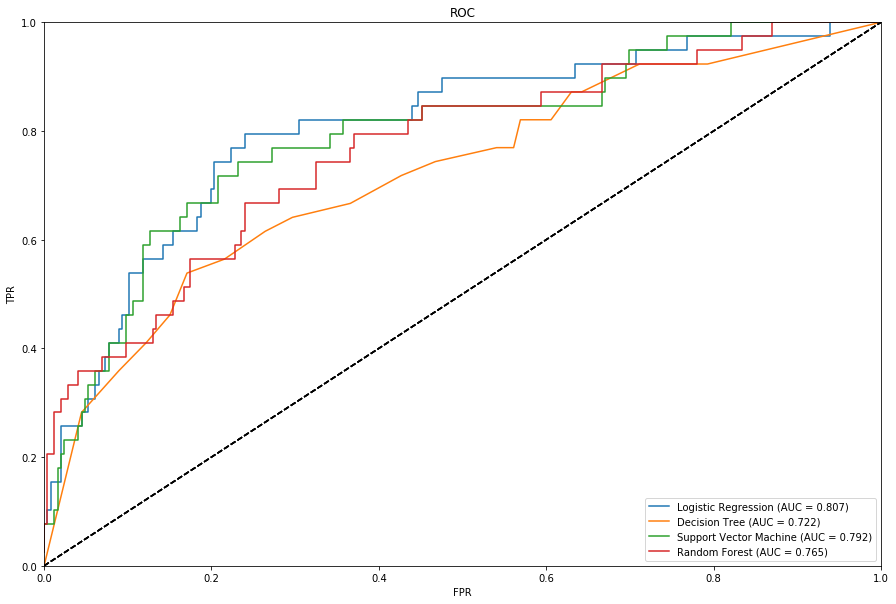

In [293]:
# Logistic regression
mi_lg = linear_model.LogisticRegression(C = 1, solver = 'liblinear')
mi_lg.fit(mi_train.drop(['Attrition'], axis = 1), mi_train['Attrition'])
remi_lg = mi_lg.predict_proba(mi_test.drop(['Attrition'], axis = 1))[:, 1]
# Decision Tree
mi_DT = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 35, min_samples_split = 80)
mi_DT.fit(mi_train.drop(['Attrition'], axis = 1), mi_train['Attrition'])
remi_DT = mi_DT.predict_proba(mi_test.drop(['Attrition'], axis = 1))[:, 1]
# Support vector machine
mi_svm = svm.SVC(kernel = 'linear', probability = True)
mi_svm.fit(mi_train.drop(['Attrition'], axis = 1), mi_train['Attrition'])
remi_svm = mi_svm.predict_proba(mi_test.drop(['Attrition'], axis = 1))[:, 1]
# Random Forest
mi_rf = RandomForestClassifier(criterion = 'entropy', min_samples_leaf = 12, min_samples_split = 4)
mi_rf.fit(mi_train.drop(['Attrition'], axis = 1), mi_train['Attrition'])
remi_rf = mi_rf.predict_proba(mi_test.drop(['Attrition'], axis = 1))[:, 1]
# plot
fig = plt.figure(figsize = (15, 10))
plotROC(remi_lg, mi_test['Attrition'], 'Logistic Regression')
plotROC(remi_DT, mi_test['Attrition'], 'Decision Tree')
plotROC(remi_svm, mi_test['Attrition'], 'Support Vector Machine')
plotROC(remi_rf, mi_test['Attrition'], 'Random Forest')
plt.show()

In [133]:
# Since apparaently, mi training doesn't help much... so we abandon it
# Make a cumulative gain curve
X_train = data_train.drop('Attrition', axis = 1)
Y_train = data_train['Attrition']
X_val = data_test.drop('Attrition', axis = 1)
Y_val = data_test['Attrition']

In [286]:
# Create data frame with predicted probability
cg_df_dtdraft = pd.DataFrame({'Attrition': Attrition_result[test_index]})
cg_df_dtdraft['Predicted Prob'] = Result_DT
cg_dt_df = cg_df_dtdraft.sort_values(by = 'Predicted Prob', ascending = False)

# Create a dataframe with predicted probability of success for each instance from lg
cg_df_lgdraft = pd.DataFrame({'Attrition': Attrition_result[test_index]})
cg_df_lgdraft['Predicted Prob'] = Result_lg
cg_lg_df = cg_df_lgdraft.sort_values(by = 'Predicted Prob', ascending = False)

# Now svm
cg_df_svmdraft = pd.DataFrame({'Attrition': Attrition_result[test_index]})
cg_df_svmdraft['Predicted Prob'] = Result_svm
cg_svm_df = cg_df_svmdraft.sort_values(by = 'Predicted Prob', ascending = False)

# Now random forest
cg_df_rfdraft = pd.DataFrame({'Attrition': Attrition_result[test_index]})
cg_df_rfdraft['Predicted Prob'] = Result_rf
cg_rf_df = cg_df_rfdraft.sort_values(by = 'Predicted Prob', ascending = False)
# Create a function to add a column for cumulative opportunity amount
def cumulative_gain(algorithm_df):
    cumulative_gain = []
    gain = algorithm_df['Attrition'].values
    length = len(gain)
    for i in range(length):
        if i == 0:
            if algorithm_df['Attrition'].iloc[i] == 1:
                cumulative_gain.append(1)
            else:
                cumulative_gain.append(0)
        else:
            if algorithm_df['Attrition'].iloc[i] == 1:
                cumulative_gain.append(1 + cumulative_gain[i - 1])
            else:
                cumulative_gain.append(cumulative_gain[i - 1])
    return cumulative_gain

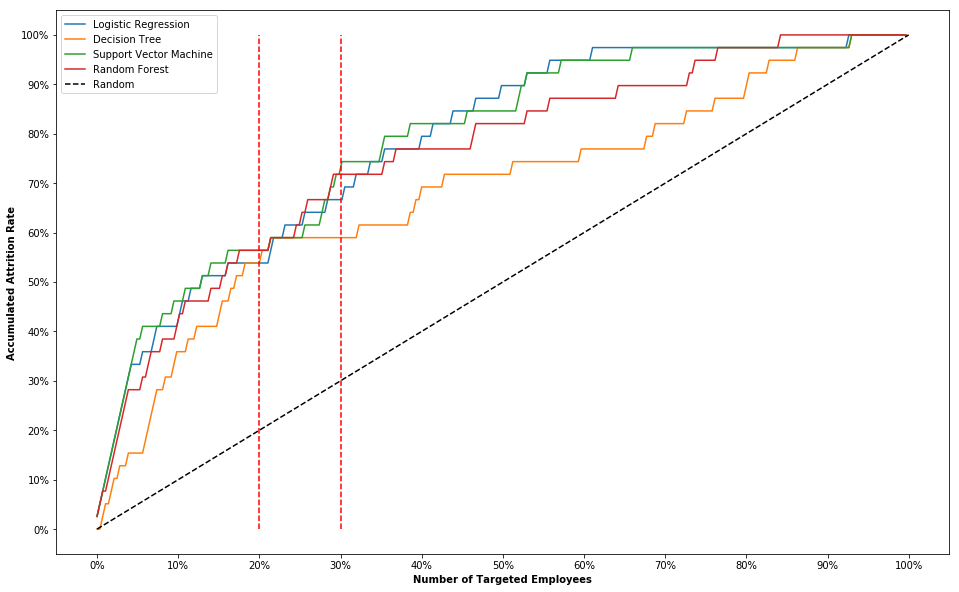

In [287]:
from matplotlib.ticker import PercentFormatter

# # Define function for axis labels in million dollars
# def percent(x, pos):
#     return '$%1.1fM' % (x*1e-6)

f, ax = plt.subplots(figsize=(16,10))
cumulative_gain_lg = cumulative_gain(cg_lg_df)
cumulative_gain_dt = cumulative_gain(cg_dt_df)
cumulative_gain_svm = cumulative_gain(cg_svm_df)
cumulative_gain_rf = cumulative_gain(cg_rf_df)

count = len(test_index)
total_attrition = sum(cg_dt_df['Attrition'].values == 1)
lgp = ax.plot(range(len(cumulative_gain_lg)), cumulative_gain_lg, label = 'Logistic Regression')
dtp = ax.plot(range(len(cumulative_gain_dt)), cumulative_gain_dt, label = 'Decision Tree')
svmp = ax.plot(range(len(cumulative_gain_svm)), cumulative_gain_svm, label = 'Support Vector Machine')
rfp =ax.plot(range(len(cumulative_gain_rf)), cumulative_gain_rf, label = 'Random Forest')
rdp = ax.plot([0, count], [0, total_attrition], 'k--', label = 'Random')
line1 = ax.plot([count * 0.2, count * 0.2], [0, total_attrition], 'r--')
line2 = ax.plot([count * 0.3, count * 0.3], [0, total_attrition], 'r--')

# Convert xticks and yticks to percent
yformatter = PercentFormatter(xmax = total_attrition)
xformatter = PercentFormatter(xmax = count)
ax.set_xticks(np.linspace(0, count, 11))
ax.set_yticks(np.linspace(0, total_attrition, 11))
ax.yaxis.set_major_formatter(yformatter)
ax.xaxis.set_major_formatter(xformatter)

# Add axis labels
plt.xlabel("Number of Targeted Employees", fontweight = "bold")
plt.ylabel("Accumulated Attrition Rate", fontweight = "bold")

plt.legend()
plt.show()

We could see from the cumulative gain curve that if we use svm, then if we target the top 20% most possible leaving employees, we target about 55% attrition employees, and if we target the top 30% of most possible leaving employees, we target about 72% attrition employees.

In [137]:
cg_svm_df.iloc[:20]

,Attrition,Predicted Prob
194,1,0.897386
7,1,0.828830
126,1,0.823512
246,1,0.784065
77,1,0.783475
154,1,0.700941
182,1,0.657431
196,1,0.653587
23,1,0.621300
174,1,0.619458


Notice that the top 15 most possible attrition employee found by svm indeed leave, so we focus on these 15 employees and figure out what could we do to stop them to leave the company.

In [219]:
data_change = data.iloc[data_test.iloc[list(cg_svm_df.iloc[0:15].index)].index]
data_change = data_change.drop(['Over18', 'StandardHours', 'EmployeeCount', 'EmployeeNumber'], axis = 1)
result = np.array((data_change['Attrition'] == 'Yes').astype(int))
data_change = data_change.drop('Attrition', axis = 1)

In [220]:
for col in data_change.columns:
    if is_string_dtype(data_change[col]):
        for name in col_name_dict[col]:
            data_change[' '.join([col, name, 'indicator'])] = (data_change[col] == name).astype(int)
        data_change = data_change.drop(col, axis = 1)
data_change

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole Laboratory Technician indicator,JobRole Manager indicator,JobRole Human Resources indicator,JobRole Healthcare Representative indicator,JobRole Research Director indicator,MaritalStatus Single indicator,MaritalStatus Married indicator,MaritalStatus Divorced indicator,OverTime No indicator,OverTime Yes indicator
1060,24,381,9,3,2,89,3,1,1,3172,...,1,0,0,0,0,1,0,0,0,1
26,32,1125,16,1,2,72,1,1,1,3919,...,0,0,0,0,0,1,0,0,0,1
656,32,374,25,4,1,87,3,1,4,2795,...,1,0,0,0,0,1,0,0,0,1
1313,29,350,13,3,1,56,2,1,1,2335,...,0,0,1,0,0,0,0,1,0,1
385,30,464,4,3,3,40,3,1,4,2285,...,0,0,0,0,0,1,0,0,0,1
829,33,603,9,4,1,77,3,2,1,8224,...,0,0,0,0,0,1,0,0,0,1
1006,49,1475,28,2,1,97,2,2,1,4284,...,1,0,0,0,0,1,0,0,1,0
1077,29,224,1,4,1,100,2,1,1,2362,...,0,0,0,0,0,1,0,0,1,0
102,20,871,6,3,4,66,2,1,4,2926,...,1,0,0,0,0,1,0,0,0,1
947,52,1030,5,3,2,64,3,3,2,8446,...,0,0,0,0,0,1,0,0,0,1


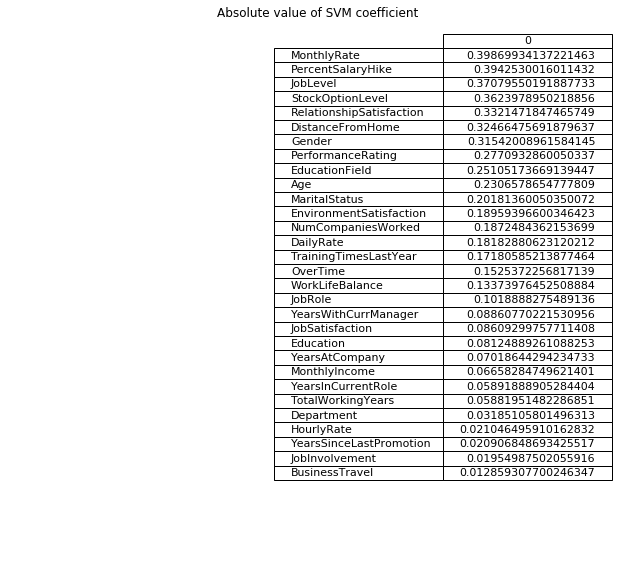

In [264]:
svm_coef_dict = dict(zip(col_list, list(np.abs(good_svm.coef_).ravel())))
svmc_df = pd.DataFrame.from_dict(svm_coef_dict, orient = 'index').sort_values(by = 0, ascending = False)

fig, ax = plt.subplots(figsize=(11, 10)) # set size frame 
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, svmc_df, loc='upper right', colWidths=[0.23]*len(svmc_df.columns))
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(11) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) # change size table
plt.title('Absolute value of SVM coefficient')
#plt.savefig('table.png', transparent=True)
plt.show()

## The part below is still a draft. Ignore for now.

In [252]:
data_after = data_change.copy()
# Write a function to change some values in the features based on mutual information
# The principle here is that at most we change two features because in reality, it is unrealistic to change
# too much features of a employee just to let the employee stay
def change_status(employee):
    change = {}
    # First check salary
    income = employee['MonthlyIncome']
    if income < 5000:
        employee['MonthlyIncome'] = income + 1000
        change['Income'] = ' '.join([str(income), 'to', str(income + 1000)])
    # Then check predicted rate again, if still large, try to change over_time status
    if predict_again(employee) > 0.5:
        if employee['OverTime Yes indicator'] == 1:
            employee['OverTime Yes indicator'] == 0
            employee['OverTime No indicator'] == 1
            change['Overtime'] = 'no overtime work'
        # Now consider YearsInCurrentRole
        if predict_again(employee) > 0.5:
            if employee['YearsInCurrentRole'] != 0:
                employee['YearsInCurrentRole'] == 0
                change['Role'] = 'Promotion!'
            # Consider Job Satisfation
            if predict_again(employee) > 0.5:
                level = employee['JobSatisfaction']
                employee['JobSatisfaction'] = level + 1
                change['JobSatisfaction'] = ' '.join(['from', str(level), 'to', str(4)])
    return employee, change
    
# Write a function which could return the updated employee's predicted attrition rate
def predict_again(employee):
    employee = pd.DataFrame(scale.transform(employee.values.reshape(1, -1)), 
                            columns = data_change.columns)
    return good_svm.predict_proba(employee)[:, 1]

In [253]:
EM = data_change.iloc[1].copy()
employee, change = change_status(EM)
print(predict_again(employee))
print(change)
#pd.DataFrame(scale.transform(data_change.iloc[0].values.reshape(1, -1)), columns = data_change.columns)

[0.7792939]
{'Income': '3919 to 4919', 'Overtime': 'no overtime work', 'Role': 'Promotion!', 'JobSatisfaction': 'from 1 to 4'}


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
